In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, AveragePooling2D, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization,RepeatVector, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Автокодировщик

основная модель MNIST-MNIST

In [2]:
def base_model_Autoencoder(level = 2, input_size=(28,28,1), kernel_list=[32,64]):

  img_input = Input(input_size)

  x = Conv2D(kernel_list[0], (3, 3), padding='same', activation='relu')(img_input)
  x = BatchNormalization()(x)
  x = Conv2D(kernel_list[0], (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)

  for i in range(level-1):
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
  x1 = x
  print(x1.shape)

  for i in range(level-1) :
    k = -(level-1)+i  

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
     
    x = Conv2D(kernel_list[k], (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

  x = Conv2DTranspose(kernel_list[0], (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(kernel_list[0], (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(kernel_list[0], (3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  model = Model(img_input, x)
   
  modelviz0=Model(img_input, x1)
  model.compile(optimizer=Adam(),
                  loss='mean_squared_error',
                  metrics=['accuracy'])

  return model, modelviz0

Читаем MNIST

In [3]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data()

noice =1

xTrainMnist = xTrainMnist.astype('float32')/255

xTrainMnist = xTrainMnist.reshape(xTrainMnist.shape[0], 28, 28, 1)

yTrainMnist_pix = xTrainMnist.copy()
xTrainMnist += np.random.randn(xTrainMnist.shape[0],xTrainMnist.shape[1],xTrainMnist.shape[2],xTrainMnist.shape[3]) * noice

11493376/11490434 [==============================] - 1s 0us/step


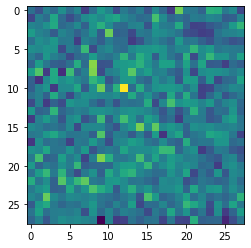

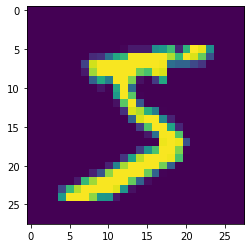

In [4]:
plt.imshow(xTrainMnist[0,:,:,0])
plt.show()
plt.imshow(yTrainMnist_pix[0,:,:,0])
plt.show()

Собираем модель


In [5]:
modelAutoMnist, m0 = base_model_Autoencoder(level = 2, input_size=(28,28,1), kernel_list=[32,64])

(None, 7, 7, 64)


In [6]:

#modelAutoMnist = denoiseAutoencoder()
hist=modelAutoMnist.fit(xTrainMnist[:10000], yTrainMnist_pix[:10000], epochs=10, batch_size=100, validation_split=0.2)

Epoch 1/10
80/80 [==============================] - 2s 25ms/step - loss: 0.0732 - accuracy: 0.7679 - val_loss: 0.0997 - val_accuracy: 0.8074
Epoch 2/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0338 - accuracy: 0.8041 - val_loss: 0.1008 - val_accuracy: 0.8074
Epoch 3/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0303 - accuracy: 0.8051 - val_loss: 0.0920 - val_accuracy: 0.8077
Epoch 4/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0285 - accuracy: 0.8057 - val_loss: 0.0699 - val_accuracy: 0.8086
Epoch 5/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0275 - accuracy: 0.8060 - val_loss: 0.0393 - val_accuracy: 0.8084
Epoch 6/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0268 - accuracy: 0.8063 - val_loss: 0.0326 - val_accuracy: 0.8081
Epoch 7/10
80/80 [==============================] - 2s 20ms/step - loss: 0.0259 - accuracy: 0.8066 - val_loss: 0.0303 - val_accuracy: 0.8077
Epoch 8/10
80

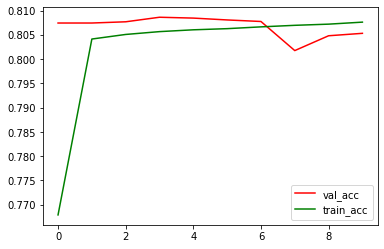

In [7]:
plt.plot(hist.history['val_accuracy'],'r',label='val_acc')
plt.plot(hist.history['accuracy'],'g',label='train_acc')
plt.legend()
plt.show()

In [8]:
modelAutoMnist.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

In [9]:
mask = np.where(yTrainMnist == 0)

y_pred=modelAutoMnist.predict(xTrainMnist[mask[0]])

ff=m0.predict(xTrainMnist[mask[0]])
print(ff.shape)

ff = np.mean(ff, axis=0)
print(ff.shape)



(5923, 7, 7, 64)
(7, 7, 64)


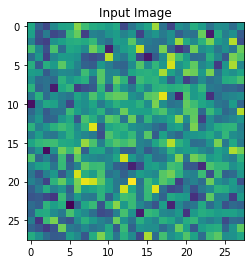

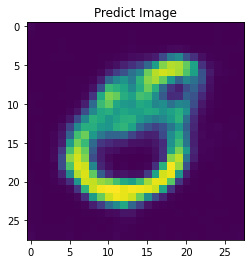

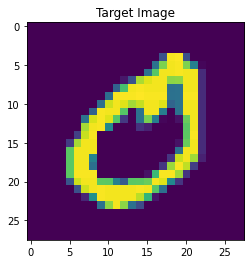

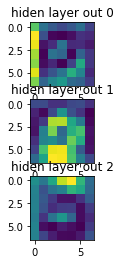

In [11]:
plt.imshow(xTrainMnist[mask[0]][1,:,:,0])
plt.title('Input Image')
plt.show()
plt.imshow(y_pred[1,:,:,0])
plt.title('Predict Image')
plt.show()
plt.imshow(yTrainMnist_pix[mask[0]][1,:,:,0])
plt.title('Target Image')
plt.show()

g1=ff[:,:,0]
plt.subplot(311)
plt.title('hiden layer out 0')
plt.imshow(g1)
g1=ff[:,:,1]
plt.subplot(312)
plt.title('hiden layer out 1')
plt.imshow(g1)
g1=ff[:,:,2]
plt.subplot(313)
plt.title('hiden layer out 2')
plt.imshow(g1)
plt.show()

# Визуализация слоев

средний объект - идеал??? 

(5923, 28, 28, 32)
(28, 28, 32)


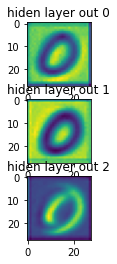

In [13]:
activ_model_layer = Model(inputs=modelAutoMnist.input, outputs = modelAutoMnist.layers[3].output)

ff = activ_model_layer.predict(xTrainMnist[mask[0]])


print(ff.shape)


ff = np.mean(ff, axis=0)
print(ff.shape)

g1=ff[:,:,0]
plt.subplot(311)
plt.title('hiden layer out 0')
plt.imshow(g1)
g1=ff[:,:,2]
plt.subplot(312)
plt.title('hiden layer out 1')
plt.imshow(g1)
g1=ff[:,:,5]
plt.subplot(313)
plt.title('hiden layer out 2')
plt.imshow(g1)
plt.show()

In [14]:
(xT_fash, yT_fash), (xTest_f, yTest_f) = fashion_mnist.load_data()

noice =0.35

xT_fash = xT_fash.astype('float32')/255

xT_fash = xT_fash.reshape(xT_fash.shape[0], 28, 28, 1)

xT_fash += np.random.randn(xT_fash.shape[0],xT_fash.shape[1],xT_fash.shape[2],xT_fash.shape[3]) * noice



4423680/4422102 [==============================] - 0s 0us/step


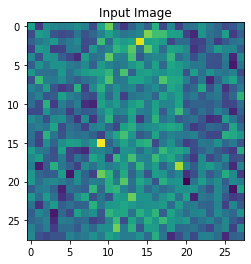

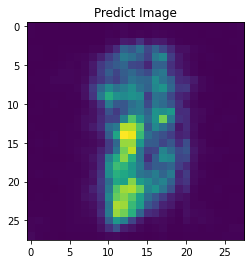

In [15]:
y_pred=modelAutoMnist.predict(xT_fash[:20])
N=2
plt.imshow(xT_fash[N,:,:,0])
plt.title('Input Image')
plt.show()
plt.imshow(y_pred[N,:,:,0])
plt.title('Predict Image')
plt.show()
